In [1]:
import os
from tqdm import tqdm
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

import colorsys
from PIL import Image, ImageDraw, ImageFont


from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D
from keras.layers import BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import plot_model
from IPython.display import Image
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import keras.backend as K   
import tensorflow as tf


/home/yinyunjie/anaconda3/envs/keras/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [28]:
ROOT_DIR = '/media/yinyunjie/WD_HDD/dataSets/raccoon/raccoon_dataset-master'

DATA_PATH = os.path.join(ROOT_DIR, 'data')

#DATA_SET_PATH = os.path.join(DATA_PATH, 'raccoon')

ANNOTATIONS_PATH = os.path.join(ROOT_DIR, 'annotations/')

IMAGES_PATH = os.path.join(ROOT_DIR, 'images/')


In [29]:
map_classes = {0: 'raccoon'}

labels = list(map_classes.values())

In [30]:
LABELS = labels

IMAGE_H, IMAGE_W = 416, 416
GRID_H, GRID_W = 13, 13
BOX = 5
CLASS = len(LABELS)
CLASS_WEIGHTS = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD = 0.3
NMS_THRESHOLD = 0.3
ANCHORS = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
NO_OBJECT_SCALE = 1.0
OJECT_SCALE = 5.0
COORD_SCALE = 1.0
CLASS_SCALE = 1.0
BATCH_SIZE = 16
WARM_UP_BATCHS = 0
TRUE_BOX_BUFFER = 50

wt_path = '/media/yinyunjie/WD_HDD/project/weights/yolov2.weights'

train_image_folder = IMAGES_PATH
train_annot_folder = ANNOTATIONS_PATH
valid_image_folder = IMAGES_PATH
valid_annot_folder = ANNOTATIONS_PATH


In [7]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [8]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER, 4))

# layer 1
x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# layer 2
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# layer 3
x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 4
x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 5
x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# layer 6
x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 7
x = Conv2D(128, (1, 1), strides=(1, 1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 8
x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# layer 9
x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 10
x = Conv2D(256, (1, 1), strides=(1, 1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 11
x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 12
x = Conv2D(256, (1, 1), strides=(1, 1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 13
x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x
x = MaxPooling2D(pool_size=(2, 2))(x)

# layer 14
x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 15
x = Conv2D(512, (1, 1), strides=(1, 1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 16
x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 17
x = Conv2D(512, (1, 1), strides=(1, 1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 18
x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 19
x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 20
x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 21
skip_connection = Conv2D(64, (1, 1), strides=(1, 1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# layer 22
x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)

output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)
output = Lambda(lambda args: args[0])([output, true_boxes])

%matplotlib inline
model = Model([input_image, true_boxes], output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

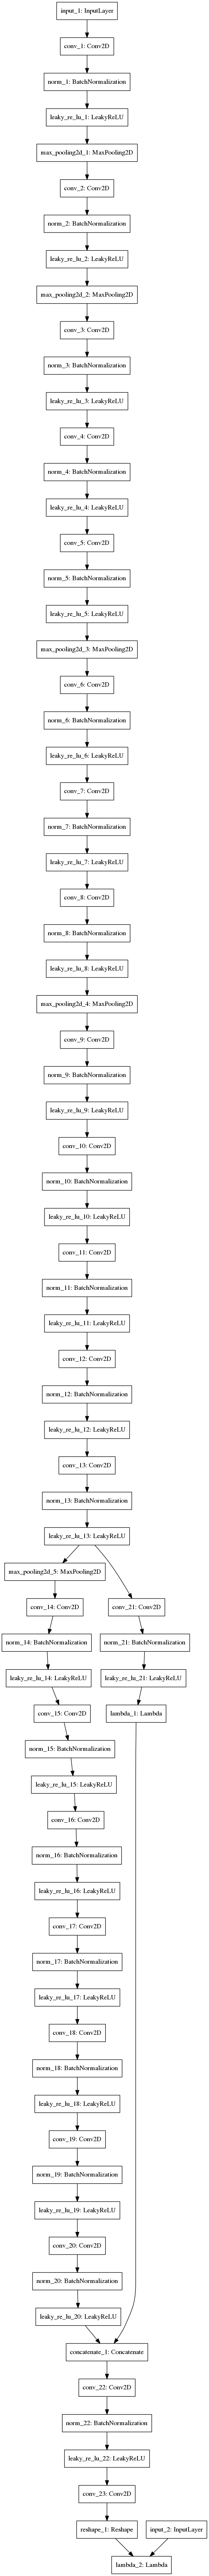

In [7]:
%matplotlib inline
plot_model(model, to_file='yolo_v2-raccoon-dataset.png')
Image('yolo_v2-raccoon-dataset.png')

### Load weights provided by YOLO

In [9]:
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes
from utils import 


wight_reader = WeightReader(wt_path)
wight_reader.reset()

nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    # 在conv_1~conv_22的卷積組合裡都包含了"conv + norm"二層, 只有conv_23是獨立一層    
    if i < nb_conv: 
        print("handle norm_" + str(i) + " start")        
        norm_layer = model.get_layer('norm_' + str(i)) # 取得BatchNormalization層
        
        size = np.prod(norm_layer.get_weights()[0].shape) # 取得BatchNormalization層的參數量
        print("shape: ", norm_layer.get_weights()[0].shape)
        
        beta  = wight_reader.read_bytes(size)
        gamma = wight_reader.read_bytes(size)
        mean  = wight_reader.read_bytes(size)
        var   = wight_reader.read_bytes(size)
        weights = norm_layer.set_weights([gamma, beta, mean, var])
        print("handle norm_" + str(i) + " completed")
        
    if len(conv_layer.get_weights()) > 1:
        print("handle conv_" + str(i) + " start")  
        print("len:",len(conv_layer.get_weights()))
        bias   = wight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = wight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
        print("handle conv_" + str(i) + " completed")
    else:
        print("handle conv_" + str(i) + " start")        
        kernel = wight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2, 3, 1, 0])
        conv_layer.set_weights([kernel])
        print("handle conv_" + str(i) + " completed")
    


handle norm_1 start


shape:  (32,)
handle norm_1 completed
handle conv_1 start
handle conv_1 completed
handle norm_2 start


shape:  (64,)
handle norm_2 completed
handle conv_2 start
handle conv_2 completed
handle norm_3 start


shape:  (128,)
handle norm_3 completed
handle conv_3 start
handle conv_3 completed
handle norm_4 start


shape:  (64,)
handle norm_4 completed
handle conv_4 start
handle conv_4 completed
handle norm_5 start


shape:  (128,)
handle norm_5 completed
handle conv_5 start
handle conv_5 completed
handle norm_6 start


shape:  (256,)
handle norm_6 completed
handle conv_6 start
handle conv_6 completed
handle norm_7 start


shape:  (128,)
handle norm_7 completed
handle conv_7 start


handle conv_7 completed
handle norm_8 start
shape:  (256,)
handle norm_8 completed
handle conv_8 start


handle conv_8 completed
handle norm_9 start
shape:  (512,)
handle norm_9 completed
handle conv_9 start


handle conv_9 completed
handle norm_10 start
shape:  (256,)
handle norm_10 completed
handle conv_10 start


handle conv_10 completed
handle norm_11 start
shape:  (512,)
handle norm_11 completed
handle conv_11 start


handle conv_11 completed
handle norm_12 start
shape:  (256,)
handle norm_12 completed
handle conv_12 start


handle conv_12 completed
handle norm_13 start
shape:  (512,)
handle norm_13 completed
handle conv_13 start


handle conv_13 completed
handle norm_14 start
shape:  (1024,)
handle norm_14 completed
handle conv_14 start


handle conv_14 completed
handle norm_15 start
shape:  (512,)
handle norm_15 completed
handle conv_15 start


handle conv_15 completed
handle norm_16 start
shape:  (1024,)
handle norm_16 completed
handle conv_16 start


handle conv_16 completed
handle norm_17 start
shape:  (512,)
handle norm_17 completed
handle conv_17 start


handle conv_17 completed
handle norm_18 start
shape:  (1024,)
handle norm_18 completed
handle conv_18 start


handle conv_18 completed
handle norm_19 start
shape:  (1024,)
handle norm_19 completed
handle conv_19 start


handle conv_19 completed
handle norm_20 start
shape:  (1024,)
handle norm_20 completed
handle conv_20 start


handle conv_20 completed
handle norm_21 start
shape:  (64,)
handle norm_21 completed
handle conv_21 start


handle conv_21 completed
handle norm_22 start
shape:  (1024,)
handle norm_22 completed
handle conv_22 start


handle conv_22 completed
handle conv_23 start
len: 2
handle conv_23 completed


## Fine tune model's weights

In [11]:
layer = model.layers[-4]    # 提出最后一层的卷积层
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape) / (GRID_H * GRID_W)
new_bias   = np.random.normal(size=weights[1].shape) / (GRID_H * GRID_W)

layer.set_weights([new_kernel, new_bias])


## Train model

### Loss

In [16]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0, 2, 1, 3, 4))
    
    cell_grid = tf.tile(tf.concat([cell_x, cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    # Adjust prediction
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid  
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1, 1, 1, BOX, 2])
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    pred_box_class = y_pred[..., 5:]
    
    # Adjust ground truth
    true_box_xy = y_true[..., 0:2]
    true_box_wh = y_true[..., 2:4]
    
    true_wh_half = true_box_wh / 2.
    true_mins = true_box_xy - true_wh_half
    true_maxes = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins = pred_box_wh - pred_wh_half
    pred_maxes = pred_box_wh + pred_wh_half
    
    intersect_mins  = tf.maximum(pred_mins, true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]
    
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half
    
    intersect_mins  = tf.maximum(pred_mins, true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    conf_mask = conf_mask + y_true[..., 4] * OJECT_SCALE
    
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE
    
    
    # Warm-up training 
    
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE / 2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHS),
                            lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask,
                                     true_box_wh + tf.ones_like(true_box_wh) * 
                                     np.reshape(ANCHORS, [1, 1, 1, BOX, 2]) * no_boxes_mask,
                                     tf.ones_like(coord_mask)],
                            lambda: [true_box_xy,
                                     true_box_wh,
                                     coord_mask])
    
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy - pred_box_xy)     * coord_mask) / \
                                                                (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh - pred_box_wh)     * coord_mask) / \
                                                                (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf - pred_box_conf) * conf_mask)  / (nb_conf_box + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, 
                                                                logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * 
                                tf.to_float(pred_box_conf> 0.3))
    
    
    # Debugging code
    current_recall = nb_pred_box / (nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall)
    
    loss = tf.Print(loss, [tf.zeros((1))], message='Dummpy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss 

In [50]:
def normalize(image):
    return image / 255.

### BatchGenerator

In [51]:
generator_config = {
    'IMAGE_H'       : IMAGE_H,
    'IMAGE_W'       : IMAGE_W,
    'GRID_H'        : GRID_H,
    'GRID_W'        : GRID_W,
    'BOX'           : BOX,
    'LABELS'        : LABELS,
    'CLASS'         : len(LABELS),
    'ANCHORS'       : ANCHORS,
    'BATCH_SIZE'    : BATCH_SIZE,
    'TRUE_BOX_BUFFER': 50
}

train_imgs, seen_train_labels = parse_annotation(ANNOTATIONS_PATH, train_image_folder, labels=LABELS)
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

valid_imgs, seen_valid_labels = parse_annotation(valid_annot_folder, valid_image_folder, 
                                                 labels=LABELS)
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)



In [39]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.001,
                           patience=15,
                           mode='min',
                           verbose=1)

checkpoint = ModelCheckpoint('weights_raccoon.h5', monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=1)

In [ ]:
optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
# optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)



In [53]:
history = model.fit_generator(generator = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 20, # 進行200個訓練循環
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint], 
                    max_queue_size   = 3)


Epoch 1/20


 1/13 [=>............................] - ETA: 9:52 - loss: 4.0276

 2/13 [===>..........................] - ETA: 8:22 - loss: 4.2280

 3/13 [=====>........................] - ETA: 7:24 - loss: 3.9882

 4/13 [========>.....................] - ETA: 6:35 - loss: 3.8835

 5/13 [==========>...................] - ETA: 5:48 - loss: 3.8122

 6/13 [============>.................] - ETA: 5:02 - loss: 3.5492

 7/13 [===============>..............] - ETA: 4:18 - loss: 3.4673

 8/13 [=================>............] - ETA: 3:34 - loss: 3.3145

 9/13 [===================>..........] - ETA: 2:51 - loss: 3.1773

10/13 [======================>.......] - ETA: 2:08 - loss: 3.0071

11/13 [========================>.....] - ETA: 1:25 - loss: 3.0089

12/13 [==========================>...] - ETA: 42s - loss: 2.9361 

13/13 [==============================] - 732s 56s/step - loss: 2.9581 - val_loss: 1.6351



Epoch 00001: val_loss improved from inf to 1.63510, saving model to weights_raccoon.h5


Epoch 2/20


 1/13 [=>............................] - ETA: 8:45 - loss: 1.0513

 2/13 [===>..........................] - ETA: 7:55 - loss: 1.0095

 3/13 [=====>........................] - ETA: 7:11 - loss: 1.2795

KeyboardInterrupt: 

## Detect Test

In [ ]:
model.load_weights('weights_raccon.h5')

dummy_array = np.zeros((1, 1, 1, 1, TRUE_BOX_BUFFER, 4))


img_filepath = train_imgs[np.random.randint(len(train_imgs))]['filename']

image = cv2.imread(img_filepath)
plt.figure(figsize=(10, 10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS,
                      nb_class=CLASS)

image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image)
plt.show()